# Plot a histogram of arm choices for each stationary period.

Use the environment from experiment 37.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle
import math

import algorithms
import evaluation
from src import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,4,4,3,2,3
12953,4,4,3,2,1
12955,4,4,3,2,3
12956,4,4,3,2,1


In [6]:
all_rewards

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [7]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [8]:
all_rewards.shape[0]

10000

In [9]:
stationarity_regions = [
    slice(0, 1000),
    slice(1000, 2000),
    slice(2000, 5000),
    slice(5000, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [10]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [11]:
change_point_values

[1, 1000, 2000, 5000, 8000, 10000]

In [12]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3396, 0.3366, 0.3238])

In [13]:
nonstationary_rewards = np.copy(all_rewards)
nonstationary_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(nonstationary_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        
        additional_shift = 0
        if i == 1 or i == 3:
            additional_shift = 1
        elif i == 2:
            additional_shift = 2
        
        # Cyclic shift of class labels
        arm_to = (arm_from + i + additional_shift) % n_arms
        if i > 0:
            nonstationary_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(nonstationary_rewards[region, arm_to].shape) * np.mean(nonstationary_rewards[region, arm_to])
        )

In [14]:
nonstationary_contexts.shape, nonstationary_rewards.shape

((10000, 5), (10000, 3))

## Plot expected reward

Min expected reward for arm 1: 0.24433333333333335
Min expected reward for arm 2: 0.022
Min expected reward for arm 3: 0.0


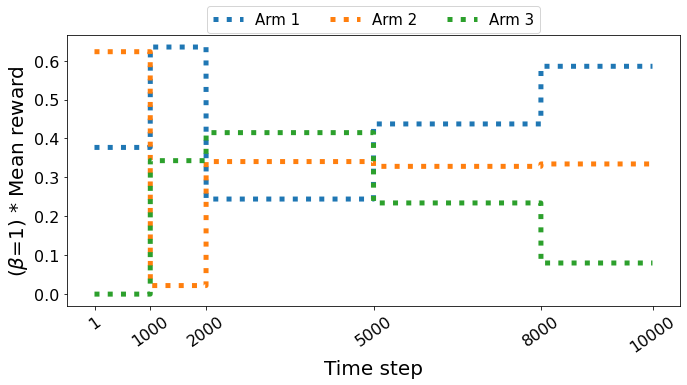

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


# Exchange rows
Here we exchange the rows between stationarity regions. We do this so that we can achieve the pattern of mean rewards as specified in the beginning of this document.

In [16]:
def exchange_rows(array, rows1:list, rows2: list):
    array = array.copy()
    assert len(rows1) == len(rows2)
    assert len(set(rows1)) == len(rows1)
    assert len(set(rows2)) == len(rows2)
    assert set(rows1).intersection(set(rows2)) == set()
    temp1 = array[rows1].copy()
    temp2 = array[rows2].copy()

    array[rows1] = temp2
    array[rows2] = temp1
    return array

In [17]:
def rebalance_arms_between_regions(
    contexts, rewards, arm_1, arm_2, region_1, region_2, percentage,
):
    assert arm_1 != arm_2
    assert region_1 != region_2
    """Exchange rows in both context and reward arrays in such a way that rows
    for arm_1 in region_1 are exchanged with arm_2 in region_2.
    
    """
    region_1_slice = stationarity_regions[region_1]
    reg_1_mask = np.zeros(contexts.shape[0], dtype=bool)
    reg_1_mask[region_1_slice] = True
    
    region_2_slice = stationarity_regions[region_2]
    reg_2_mask = np.zeros(contexts.shape[0], dtype=bool)
    reg_2_mask[region_2_slice] = True
    
    arm_1_mask = np.array(rewards[:, arm_1], dtype=bool)
    arm_2_mask = np.array(rewards[:, arm_2], dtype=bool)
    
    mask1 = arm_1_mask & reg_1_mask
    mask2 = arm_2_mask & reg_2_mask
    
    
    rows1 = np.where(mask1)[0]
    rows2 = np.where(mask2)[0]
    
    
    num_rows_to_exchange = int(
        percentage * min(len(rows1), len(rows2))
    )
    
    rows1 = list(
        np.random.choice(
            rows1,
            replace=False,
            size=num_rows_to_exchange,
        )
    )
    rows2 = list(
        np.random.choice(
            rows2,
            replace=False,
            size=num_rows_to_exchange,
        )
    )
    
    if len(rows1) > len(rows2):
        rows1 = rows1[:len(rows2)]
    else:
        rows2 = rows2[:len(rows1)]
    
    
    contexts = exchange_rows(contexts, rows1, rows2)
    rewards = exchange_rows(rewards, rows1, rows2)
    
    return contexts, rewards

In [18]:
new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=nonstationary_contexts,
    rewards=nonstationary_rewards,
    arm_1=1, 
    arm_2=2,
    region_1=2, 
    region_2=3,
    percentage=0.7,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=1,
    region_1=3, 
    region_2=4,
    percentage=0.6,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=2, 
    arm_2=1,
    region_1=1, 
    region_2=4,
    percentage=0.7,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=1,
    region_1=3, 
    region_2=1,
    percentage=0.7,
)


new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=2,
    region_1=2, 
    region_2=3,
    percentage=0.7,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=1,
    region_1=2, 
    region_2=4,
    percentage=0.8,
)



## Plot expected reward after row exchanges

In [19]:
# compute mean rewards
mean_rewards = np.zeros(new_rewards.shape)
for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # For plotting
        mean_rewards[region, arm_from] = (
            np.ones(new_rewards[region, arm_from].shape) * np.mean(new_rewards[region, arm_from])
        )

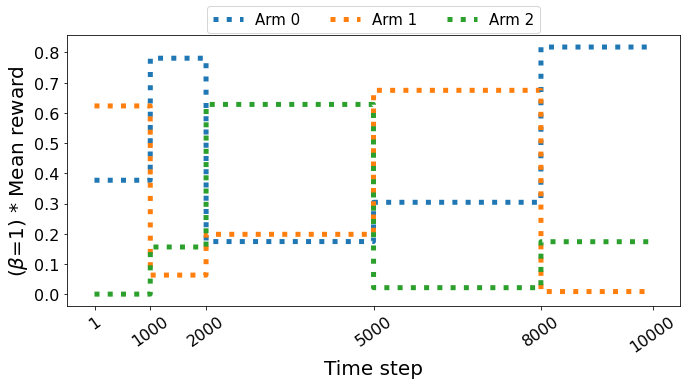

In [20]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm}", linestyle=':', linewidth=5)
#     print(f"Min expected reward for arm {arm}: {min(expected_gain)}")
    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.show()

## Validate the row exchange

Validate that no rows disappeared and now new rows appeared.

In [21]:
assert (np.sort(nonstationary_contexts, axis=0) == np.sort(new_contexts, axis=0)).all()

In [22]:
assert (np.sort(nonstationary_rewards, axis=0) == np.sort(new_rewards, axis=0)).all()

### Non-stationarity in costs

In [23]:
np.random.seed(42)

In [24]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [25]:
cost_means_range = [0.03, 0.08]

In [26]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [27]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [28]:
interval_means

[array([0.04872701, 0.07753572, 0.0665997 , 0.05993292, 0.03780093]),
 array([0.03779973, 0.03290418, 0.07330881, 0.06005575, 0.06540363]),
 array([0.03102922, 0.07849549, 0.07162213, 0.04061696, 0.03909125]),
 array([0.03917023, 0.04521211, 0.05623782, 0.05159725, 0.04456146]),
 array([0.06059264, 0.03697469, 0.04460723, 0.04831809, 0.0528035 ])]

In [29]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [30]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

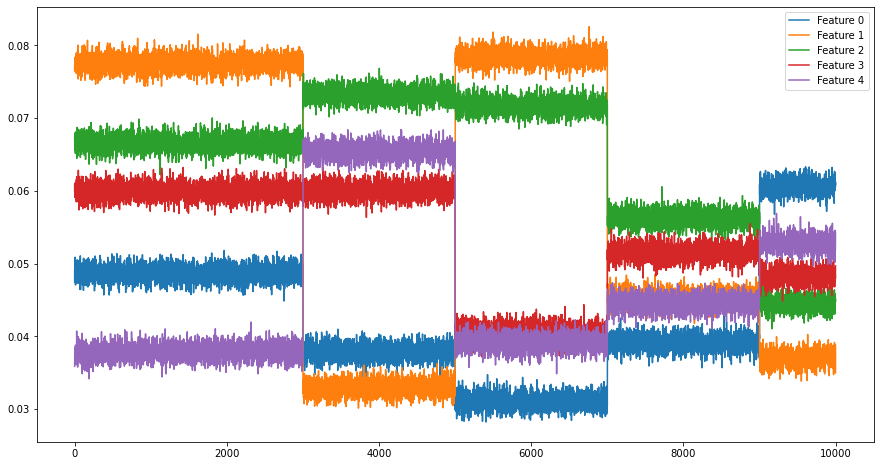

In [31]:
plot_costs(get_costs(), new_contexts.shape[0])

In [32]:
costs_obj = get_costs()

In [33]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [34]:
costs_vector.shape

(10000, 5)

## Save mean costs for plotting

In [35]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [36]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

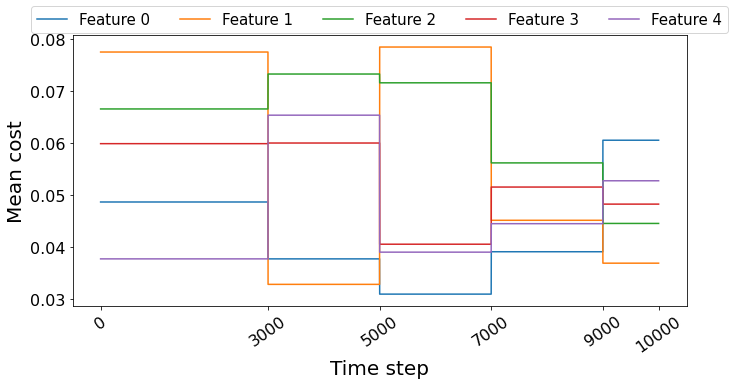

In [37]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for feature in range(new_contexts.shape[1]):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature}")

extraticks = full_cost_change_points
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"Mean cost", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()

## Plot expected reward minus sum of costs

In [38]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.12394781794797932
Min expected gain for arm 2: -0.24069385026660228
Min expected gain for arm 3: -0.29821225004764745


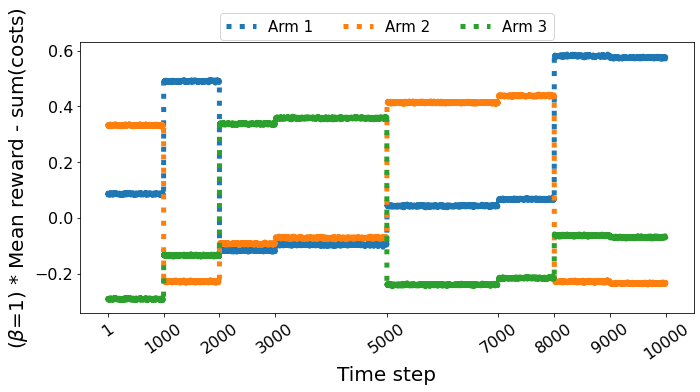

In [39]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


In [40]:
def plot_gains(gain_dict, reward_change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    max_vline=0
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    plt.vlines(reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4)
    
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

# Created change points

In [41]:
# Reward changes
change_point_values

[1, 1000, 2000, 5000, 8000, 10000]

In [42]:
# Cost changes
cost_change_points

[3000, 5000, 7000, 9000]

In [43]:
all_change_point_values

[1, 1000, 2000, 3000, 5000, 7000, 8000, 9000, 10000]

In [44]:
all_stationarity_regions = [(l, r) for l,r in zip(all_change_point_values, all_change_point_values[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

In [45]:
all_stationarity_regions

[(1, 1000),
 (1000, 2000),
 (2000, 3000),
 (3000, 5000),
 (5000, 7000),
 (7000, 8000),
 (8000, 9000),
 (9000, 10000)]

### Function to get histogram from list of chosen arms

In [46]:
def get_histograms(arms_list, regions):
    arms = np.array(arms_list)
    n_arms = len(np.unique(arms))
    n_regions = len(regions)
    histograms = np.zeros((n_regions, n_arms))
    for i, region in enumerate(regions):
        arms_in_region = arms[slice(*region)]
        region_histogram = np.zeros(n_arms)
        for arm in range(n_arms):
            region_histogram[arm] = np.count_nonzero(arms_in_region == arm)
        histograms[i, :] = region_histogram
        
    return histograms

# Running evaluation

In [47]:
# Histogram dict for every algorithm. Averaged histograms are saved
histograms = {}

In [48]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5
N_ARMS = all_rewards.shape[1]

In [49]:
gains_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random, _, _, arms_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_random[i, :] = gain_random
    hists[i, :, :] = get_histograms(arms_random, all_stationarity_regions)
    
histograms['Random'] = np.mean(hists, axis=0)
gain_random = np.mean(gains_random, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 3364.0
	Total reward: 3364.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3333.0
	Total reward: 3333.0
	Total cost: 0
Execution time: 0.0s
Random policy
Beta = 1
Total gain: 3284.0
	Total reward: 3284.0
	Total cost: 0
Execution time: 0.0s
Random policy
Beta = 1
Total gain: 3301.0
	Total reward: 3301.0
	Total cost: 0
Execution time: 0.0s
Random policy
Beta = 1
Total gain: 3405.0
	Total reward: 3405.0
	Total cost: 0
Execution time: 0.0s
Average gain: 3337.4


In [50]:
gains_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.03, n_arms=new_rewards.shape[1])

    gain_egreedy, _, _, arms_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_egreedy[i, :] = gain_egreedy
    hists[i, :, :] = get_histograms(arms_egreedy, all_stationarity_regions)
    
histograms['E-greedy'] = np.mean(hists, axis=0)
gain_egreedy = np.mean(gains_egreedy, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3796.0
	Total reward: 3796.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3816.0
	Total reward: 3816.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 4161.0
	Total reward: 4161.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3720.0
	Total reward: 3720.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3427.0
	Total reward: 3427.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3784.0


In [51]:
gains_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.6,
        )

    gain_ucb, _, _, arms_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_ucb[i, :] = gain_ucb
    hists[i, :, :] = get_histograms(arms_ucb, all_stationarity_regions)

histograms['UCB1'] = np.mean(hists, axis=0)
gain_ucb = np.mean(gains_ucb, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.6)
Beta = 1
Total gain: 5809.0
	Total reward: 5809.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5809.0
	Total reward: 5809.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5809.0
	Total reward: 5809.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5809.0
	Total reward: 5809.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5809.0
	Total reward: 5809.0
	Total cost: 0
Execution time: 0.1s
Average gain: 5809.0


In [52]:
gains_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb, _, _, arms_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_linucb[i, :] = gain_linucb
    hists[i, :, :] = get_histograms(arms_linucb, all_stationarity_regions)
    
histograms['LinUCB'] = np.mean(hists, axis=0)
gain_linucb = np.mean(gains_linucb, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 4354.682208247001
	Total reward: 7004.0
	Total cost: 2649.317791753
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 4354.682208247001
	Total reward: 7004.0
	Total cost: 2649.317791753
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 4354.682208247001
	Total reward: 7004.0
	Total cost: 2649.317791753
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 4354.682208247001
	Total reward: 7004.0
	Total cost: 2649.317791753
Execution time: 0.4s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 4354.682208247001
	Total reward: 7004.0
	Total cost: 2649.317791753
Execution time: 0.4s
Average gain: 4354.682208247001


In [53]:
gains_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.05,
    )


    gain_pslinucb, _, _, arms_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_pslinucb[i, :] = gain_pslinucb
    hists[i, :, :] = get_histograms(arms_pslinucb, all_stationarity_regions)
    
histograms['PSLinUCB'] = np.mean(hists, axis=0)
gain_pslinucb = np.mean(gains_pslinucb, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5742.682208246992
	Total reward: 8392.0
	Total cost: 2649.317791753
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5742.682208246992
	Total reward: 8392.0
	Total cost: 2649.317791753
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5742.682208246992
	Total reward: 8392.0
	Total cost: 2649.317791753
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5742.682208246992
	Total reward: 8392.0
	Total cost: 2649.317791753
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5742.682208246992
	Total reward: 8392.0
	Total cost: 2649.317791753
Execution time: 0.5s
Average gain: 5742.682208246992


In [54]:
gains_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.8,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos, _, _, arms_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos[i, :] = gain_simoos
    hists[i, :, :] = get_histograms(arms_simoos, all_stationarity_regions)
    
histograms['SimOOS'] = np.mean(hists, axis=0)
gain_simoos = np.mean(gains_simoos, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0022020339965820312 seconds
Trial 0, time 2022-06-15 13:33:52.984904
Trial 500, time 2022-06-15 13:34:04.645191
Trial 1000, time 2022-06-15 13:34:13.315062
Trial 1500, time 2022-06-15 13:34:19.547283
Trial 2000, time 2022-06-15 13:34:25.078223
Trial 2500, time 2022-06-15 13:34:38.740593
Trial 3000, time 2022-06-15 13:34:43.302146
Trial 3500, time 2022-06-15 13:35:01.833259
Trial 4000, time 2022-06-15 13:35:19.118298
Trial 4500, time 2022-06-15 13:35:23.237786
Trial 5000, time 2022-06-15 13:35:23.941293
Trial 5500, time 2022-06-15 13:35:25.045210
Trial 6000, time 2022-06-15 13:35:25.475700
Trial 6500, time 2022-06-15 13:35:25.810455
Trial 7000, time 2022-06-15 13:35:26.052503
Trial 7500, time 2022-06-15 13:35:26.194553
Trial 8000, time 2022-06-15 13:35:26.432588
Trial 8500, time 2022-06-15 13:35:26.575118
Trial 9000, time 2022-06-15 13:35:26.722391
Trial 9500, time 2022-06-15 13:35:27.716932
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 4048.5069226328087
	Total reward: 5700.0


In [55]:
gains_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=0.04,
        window_length=250,
        costs_range=COSTS_RANGE_SIZE,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1, _, _, arms_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1[i, :] = gain_alg1
        hists[i, :, :] = get_histograms(arms_alg1, all_stationarity_regions)
    
histograms['Algorithm1'] = np.mean(hists, axis=0)
gain_alg1 = np.mean(gains_alg1, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0016541481018066406 seconds
Round 0, time 2022-06-15 13:41:32.977099
Round 500, time 2022-06-15 13:42:36.234214
Round 1000, time 2022-06-15 13:43:44.822747
Round 1500, time 2022-06-15 13:44:53.034002
Round 2000, time 2022-06-15 13:46:01.153798
Round 2500, time 2022-06-15 13:47:09.809062
Round 3000, time 2022-06-15 13:48:17.834495
Round 3500, time 2022-06-15 13:49:26.888115
Round 4000, time 2022-06-15 13:50:35.021572
Round 4500, time 2022-06-15 13:51:42.077263
Round 5000, time 2022-06-15 13:52:49.821031
Round 5500, time 2022-06-15 13:53:57.104891
Round 6000, time 2022-06-15 13:55:04.313413
Round 6500, time 2022-06-15 13:56:10.928270
Round 7000, time 2022-06-15 13:57:18.250521
Round 7500, time 2022-06-15 13:58:25.257580
Round 8000, time 2022-06-15 13:59:31.961306
Round 8500, time 2022-06-15 14:00:39.208128
Round 9000, time 2022-06-15 14:01:46.460940
Round 9500, time 2022-06-15 14:02:53.464548
Algorithm1 (beta=1, delta=0.04, w=250)
Beta = 1
Total gain: 7490.325501183527
	Total rewa

## Oracle

In [56]:
cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

In [57]:
gains_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1_oracle = algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1_oracle, _, _, arms_alg1_oracle = evaluation.evaluate_on_synthetic_data(
            p_alg1_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1_oracle[i, :] = gain_alg1_oracle
        hists[i, :, :] = get_histograms(arms_alg1_oracle, all_stationarity_regions)

histograms['Oracle'] = np.mean(hists, axis=0)
gain_alg1_oracle = np.mean(gains_alg1_oracle, axis=0)
print(f"Average gain: {gain_alg1_oracle[-1]}")

Took 0.5943570137023926 seconds
Trial 0, time 2022-06-15 16:51:33.480443
Trial 500, time 2022-06-15 16:51:33.486462
Trial 1000, time 2022-06-15 16:51:33.491998
Trial 1500, time 2022-06-15 16:51:33.497208
Trial 2000, time 2022-06-15 16:51:33.502871
Trial 2500, time 2022-06-15 16:51:33.508759
Trial 3000, time 2022-06-15 16:51:33.514366
Trial 3500, time 2022-06-15 16:51:33.519835
Trial 4000, time 2022-06-15 16:51:33.525211
Trial 4500, time 2022-06-15 16:51:33.530728
Trial 5000, time 2022-06-15 16:51:33.536396
Trial 5500, time 2022-06-15 16:51:33.542079
Trial 6000, time 2022-06-15 16:51:33.547578
Trial 6500, time 2022-06-15 16:51:33.553154
Trial 7000, time 2022-06-15 16:51:33.558636
Trial 7500, time 2022-06-15 16:51:33.564356
Trial 8000, time 2022-06-15 16:51:33.569952
Trial 8500, time 2022-06-15 16:51:33.575591
Trial 9000, time 2022-06-15 16:51:33.581294
Trial 9500, time 2022-06-15 16:51:33.587083
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 8780.69062052404
	Total reward: 9245.0
	Tota

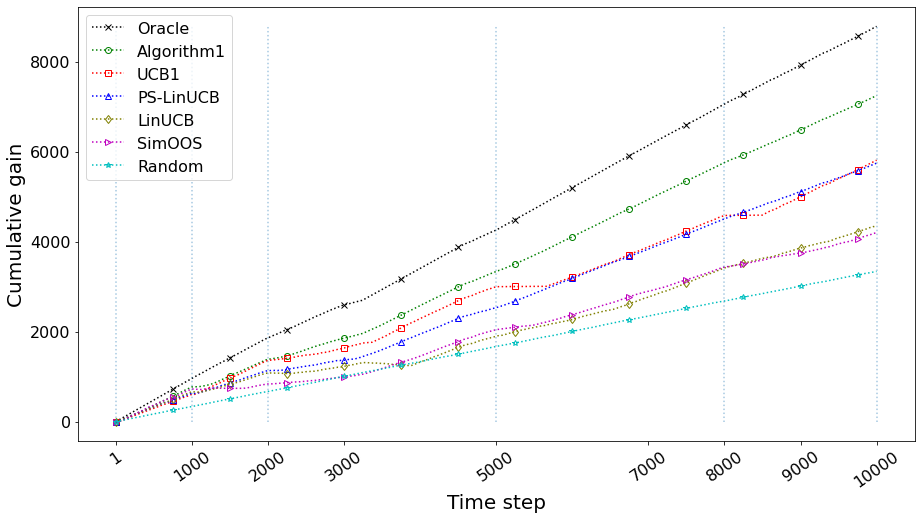

In [58]:
plot_gains(
    {
    'Random': gain_random,
#     'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
    'Oracle': gain_alg1_oracle,
    },
    reward_change_points=change_point_values,
)


## Plot the histograms for each algorithm

In [59]:
histograms

{'Random': array([[337.4, 337.4, 324.2],
        [344.6, 324.8, 330.6],
        [348.6, 328.8, 322.6],
        [681.4, 658.4, 660.2],
        [638.8, 682.4, 678.8],
        [344. , 329.2, 326.8],
        [324.2, 336.4, 339.4],
        [322.4, 338.8, 338.8]]),
 'E-greedy': array([[  38.4,  949.2,   11.4],
        [ 510.6,  478.2,   11.2],
        [ 981. ,   10. ,    9. ],
        [ 794.4,  447.8,  757.8],
        [  19.2, 1291.4,  689.4],
        [  11.4,  980.6,    8. ],
        [  10.8,  977.4,   11.8],
        [ 147.6,  844.2,    8.2]]),
 'UCB1': array([[1.300e+01, 9.780e+02, 8.000e+00],
        [9.610e+02, 3.800e+01, 1.000e+00],
        [8.250e+02, 1.390e+02, 3.600e+01],
        [2.740e+02, 9.300e+01, 1.633e+03],
        [0.000e+00, 1.333e+03, 6.670e+02],
        [0.000e+00, 1.000e+03, 0.000e+00],
        [5.040e+02, 4.940e+02, 2.000e+00],
        [1.000e+03, 0.000e+00, 0.000e+00]]),
 'LinUCB': array([[3.870e+02, 6.070e+02, 5.000e+00],
        [9.000e+02, 9.900e+01, 1.000e+00],
    

In [60]:
all_stationarity_regions

[(1, 1000),
 (1000, 2000),
 (2000, 3000),
 (3000, 5000),
 (5000, 7000),
 (7000, 8000),
 (8000, 9000),
 (9000, 10000)]

## Saving and loading data

In [61]:
data_to_save = {
    'histograms': histograms,
    'all_stationarity_regions': all_stationarity_regions,
}

In [62]:
with open('experiments/nursery/results/histograms.pickle', 'wb') as f:
    pickle.dump(data_to_save, f)

In [63]:
with open('experiments/nursery/results/histograms.pickle', 'rb') as f:
    data_to_save = pickle.load(f)

In [64]:
histograms = data_to_save['histograms']
all_stationarity_regions = data_to_save['all_stationarity_regions']

In [69]:
algs_to_plot = ["Oracle", "Algorithm1", "PSLinUCB"]
colors = ['cyan', 'red', 'blue']

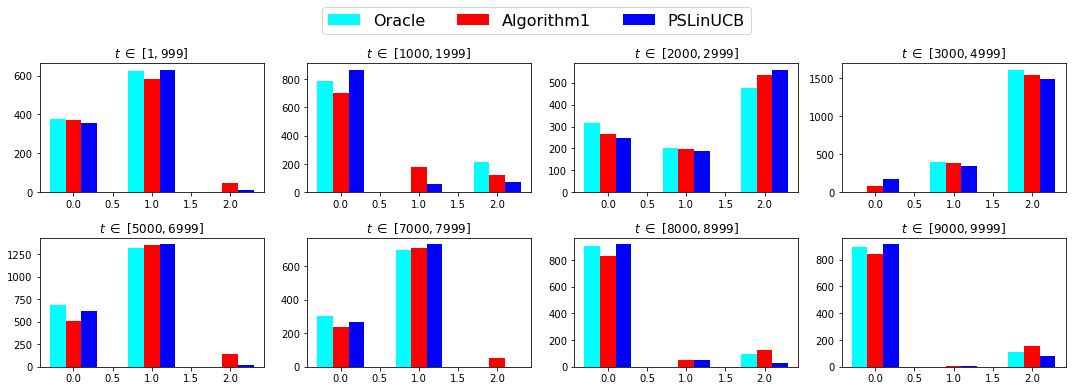

In [70]:
fig, axs = plt.subplots(2, math.floor(N_STATIONARY_PERIODS/2), figsize=(15, 5))

x = np.array([0, 1, 2])

handles = []
for period_num, ax in enumerate(axs.flatten()):
    if period_num >= N_STATIONARY_PERIODS:
        break
    for alg_num, alg_name in enumerate(algs_to_plot):
        
        bar = ax.bar(-0.2 + x+alg_num*0.2,
               histograms[alg_name][period_num, :],
               width=0.2,
               color=colors[alg_num],
               label=alg_name,
        )
        period = all_stationarity_regions[period_num]
        ax.set_title(fr"$t\ \in \ [{period[0]}, {period[1]-1}]$")
        if period_num == 0:
            handles.append(bar)
            
        


fig.legend(handles, algs_to_plot, loc="upper center",  bbox_to_anchor=(0.5, 1.1), ncol=3, prop={'size': 16})
plt.tight_layout()
plt.show()